# Black-Litterman Optimization Testing & Debugging

This notebook investigates why the Black-Litterman optimizer is producing poor results (Sharpe ~0.23) compared to Monte Carlo (Sharpe ~1.53).

## Key Questions:
1. Are factor exposures being calculated correctly?
2. Are factor timing views being created properly?
3. Is the Black-Litterman posterior calculation working?
4. Are the portfolio constraints reasonable?
5. How do the results compare to Monte Carlo?

In [ ]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from quantfolio_engine.config import PROCESSED_DATA_DIR

# Import our modules
from quantfolio_engine.optimizer.black_litterman import BlackLittermanOptimizer
from quantfolio_engine.optimizer.monte_carlo import MonteCarloOptimizer
from quantfolio_engine.data.data_loader import DataLoader
from quantfolio_engine.signals.factor_timing import FactorTimingEngine

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

2025-07-04 16:22:39.911 | INFO     | quantfolio_engine.config:<module>:12 - PROJ_ROOT path is: /Users/dominusdeorum/Documents/Vanderbilt/Projects/quantfolio-engine


✅ Imports successful


## 1. Load and Examine Data

In [ ]:
# Load data - using real-world data fetching
data_loader = DataLoader()

# Fetch fresh data (or load existing processed data if available)
try:
    # Try to load existing processed data first
    returns_df = pd.read_csv(PROCESSED_DATA_DIR / "returns_monthly.csv", index_col=0, parse_dates=True)
    factor_exposures = pd.read_csv(PROCESSED_DATA_DIR / "factor_exposures.csv", index_col=0, parse_dates=True)
    factor_regimes = pd.read_csv(PROCESSED_DATA_DIR / "factor_regimes_hmm.csv", index_col=0, parse_dates=True)
    sentiment_scores = pd.read_csv(PROCESSED_DATA_DIR / "sentiment_monthly.csv", index_col=0, parse_dates=True)
    
    print("Loaded existing processed data")
except FileNotFoundError:
    # If processed data doesn't exist, fetch fresh data
    print("Fetching fresh data...")
    returns_df, macro_df, sentiment_scores = data_loader.load_all_data()
    
    # Generate factor exposures using Fama-French method
    factor_engine = FactorTimingEngine(factor_method="fama_french")
    factor_results = factor_engine.generate_factor_timing_signals(
        returns_file=None,  # Use in-memory data
        factors_file=None
    )
    factor_exposures = factor_results["factor_exposures"]
    factor_regimes = factor_results["hmm_regimes"]
    
    print("Generated fresh data with Fama-French factors")

print("Data Summary:")
print(f"Returns shape: {returns_df.shape}")
print(f"Factor exposures shape: {factor_exposures.shape}")
print(f"Factor regimes shape: {factor_regimes.shape}")
print(f"Sentiment scores shape: {sentiment_scores.shape}")

print("\nReturns Summary:")
print(returns_df.describe())

print("\nFactor Exposures Columns:")
print(factor_exposures.columns.tolist()[:10])  # First 10 columns

✅ Loaded existing processed data
📊 Data Summary:
Returns shape: (299, 12)
Factor exposures shape: (227, 39)
Factor regimes shape: (181, 4)
Sentiment scores shape: (300, 14)

📈 Returns Summary:
              SPY         TLT         GLD        AAPL        MSFT         JPM  \
count  299.000000  269.000000  241.000000  299.000000  299.000000  299.000000   
mean     0.007316    0.003819    0.008119    0.026008    0.012040    0.011126   
std      0.044090    0.039615    0.048193    0.110614    0.079743    0.085514   
min     -0.165187   -0.130708   -0.161397   -0.577437   -0.343530   -0.280682   
25%     -0.016806   -0.022579   -0.022214   -0.036348   -0.037211   -0.035946   
50%      0.012632    0.003786    0.003809    0.029500    0.017116    0.015958   
75%      0.034329    0.024951    0.037072    0.096595    0.056281    0.059228   
max      0.126983    0.143413    0.127865    0.453783    0.407781    0.255492   

              UNH         WMT         XLE          BA         IWM         EFA

## 2. Examine Factor Exposures

In [ ]:
# Examine factor exposures structure
print("Factor Exposures Analysis:")
print(f"\nColumn naming pattern:")
sample_cols = factor_exposures.columns[:5]
for col in sample_cols:
    print(f"  {col}")

# Check for momentum and value factors
momentum_cols = [col for col in factor_exposures.columns if 'momentum' in col.lower()]
value_cols = [col for col in factor_exposures.columns if 'value' in col.lower()]

print(f"\nFactor Counts:")
print(f"Momentum factors: {len(momentum_cols)}")
print(f"Value factors: {len(value_cols)}")

# Show sample momentum exposures
if momentum_cols:
    print(f"\nSample Momentum Exposures (latest):")
    latest_momentum = factor_exposures[momentum_cols].iloc[-1]
    print(latest_momentum.sort_values(ascending=False).head())

# Show sample value exposures
if value_cols:
    print(f"\nSample Value Exposures (latest):")
    latest_value = factor_exposures[value_cols].iloc[-1]
    print(latest_value.sort_values(ascending=False).head())

🔍 Factor Exposures Analysis:

Column naming pattern:
  SPY_market
  SPY_size
  SPY_value
  SPY_momentum
  TLT_factor

📊 Factor Counts:
Momentum factors: 9
Value factors: 9

📈 Sample Momentum Exposures (latest):
AAPL_momentum    0.001524
MSFT_momentum    0.000235
SPY_momentum    -0.000007
WMT_momentum    -0.000132
UNH_momentum    -0.000780
Name: 2024-12-31 00:00:00, dtype: float64

📉 Sample Value Exposures (latest):
WMT_value     0.001412
XLE_value     0.000910
UNH_value    -0.000054
AAPL_value   -0.000823
IWM_value    -0.001064
Name: 2024-12-31 00:00:00, dtype: float64


## 3. Test Factor Timing Views Creation

In [ ]:
# Test Black-Litterman view creation
bl_optimizer = BlackLittermanOptimizer()

# Test view creation
P, Q, Omega = bl_optimizer.create_factor_timing_views(
    factor_exposures, factor_regimes, sentiment_scores
)

print("🔍 Factor Timing Views Analysis:")
print(f"Number of views created: {len(P)}")
print(f"View returns shape: {Q.shape}")
print(f"View uncertainties shape: {Omega.shape}")

if len(P) > 0:
    print(f"\nSample Views:")
    print(f"P matrix shape: {P.shape}")
    print(f"Q vector (expected returns): {Q[:5]}")
    print(f"Omega diagonal (uncertainties): {np.diag(Omega)[:5]}")
else:
    print("No views created - this explains poor performance!")

2025-07-04 16:22:40.637 | INFO     | quantfolio_engine.optimizer.black_litterman:create_factor_timing_views:157 - Creating factor timing views...
2025-07-04 16:22:40.652 | INFO     | quantfolio_engine.optimizer.black_litterman:create_factor_timing_views:312 - Created 22 factor timing views
🔍 Factor Timing Views Analysis:
Number of views created: 22
View returns shape: (22,)
View uncertainties shape: (22, 22)

📊 Sample Views:
P matrix shape: (22, 12)
Q vector (expected returns): [0.045 0.045 0.045 0.045 0.045]
Omega diagonal (uncertainties): [2.5e-05 2.5e-05 2.5e-05 2.5e-05 2.5e-05]


## 4. Compare Black-Litterman vs Monte Carlo

In [ ]:
# Run both optimizers
print("Running Black-Litterman...")
bl_results = bl_optimizer.optimize_portfolio(
    returns_df, factor_exposures, factor_regimes, sentiment_scores
)

print("\nRunning Monte Carlo...")
mc_optimizer = MonteCarloOptimizer()
# Generate scenarios first
scenarios = mc_optimizer.generate_regime_scenarios(
    returns_df, 
    macro_data=pd.DataFrame(),  # Empty DataFrame since macro not used
    factor_regimes=factor_regimes
)
# Then optimize with constraints
mc_results = mc_optimizer.optimize_with_constraints(
    scenarios=scenarios,
    asset_names=returns_df.columns.tolist()
)

print("\n�� Comparison Results:")
comparison_df = pd.DataFrame({
    'Metric': ['Expected Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'VaR (95%)'],
    'Black-Litterman': [
        bl_results['expected_return'],
        bl_results['volatility'],
        bl_results['sharpe_ratio'],
        bl_results['max_drawdown'],
        bl_results['var_95']
    ],
    'Monte Carlo': [
        mc_results['expected_return'],
        mc_results['volatility'],
        mc_results['sharpe_ratio'],
        mc_results['max_drawdown'],
        mc_results['var_95']
    ]
})

print(comparison_df.round(4))

# Calculate differences
comparison_df['Difference'] = comparison_df['Monte Carlo'] - comparison_df['Black-Litterman']
comparison_df['Ratio'] = comparison_df['Monte Carlo'] / comparison_df['Black-Litterman']
print("\nPerformance Ratios:")
print(comparison_df[['Metric', 'Ratio']].round(3))

🔄 Running Black-Litterman...
2025-07-04 16:22:40.661 | INFO     | quantfolio_engine.optimizer.black_litterman:optimize_portfolio:340 - Starting Black-Litterman portfolio optimization...
2025-07-04 16:22:40.661 | INFO     | quantfolio_engine.optimizer.black_litterman:estimate_covariance_matrix:74 - Estimating covariance matrix using sample method...
2025-07-04 16:22:40.662 | INFO     | quantfolio_engine.optimizer.black_litterman:estimate_covariance_matrix:102 - Covariance matrix shape: (12, 12)
2025-07-04 16:22:40.663 | INFO     | quantfolio_engine.optimizer.black_litterman:calculate_equilibrium_returns:134 - Calculated equilibrium returns
2025-07-04 16:22:40.663 | INFO     | quantfolio_engine.optimizer.black_litterman:create_factor_timing_views:157 - Creating factor timing views...
2025-07-04 16:22:40.669 | INFO     | quantfolio_engine.optimizer.black_litterman:create_factor_timing_views:312 - Created 22 factor timing views
2025-07-04 16:22:40.669 | INFO     | quantfolio_engine.optimiz

## 5. Examine Portfolio Weights

In [ ]:
# Compare portfolio weights
bl_weights = bl_results['weights']
mc_weights = mc_results['weights']

print("Portfolio Weight Comparison:")
weights_comparison = pd.DataFrame({
    'Asset': bl_weights.index,
    'Black-Litterman': bl_weights.values,
    'Monte Carlo': mc_weights.values
})
weights_comparison['Difference'] = weights_comparison['Monte Carlo'] - weights_comparison['Black-Litterman']

# Sort by Black-Litterman weight
weights_comparison = weights_comparison.sort_values('Black-Litterman', ascending=False)
print(weights_comparison.round(4))

# Check for concentration
print(f"\nConcentration Analysis:")
print(f"BL Top 3 weight sum: {bl_weights.nlargest(3).sum():.3f}")
print(f"MC Top 3 weight sum: {mc_weights.nlargest(3).sum():.3f}")
print(f"BL Herfindahl index: {(bl_weights**2).sum():.3f}")
print(f"MC Herfindahl index: {(mc_weights**2).sum():.3f}")

📊 Portfolio Weight Comparison:
   Asset  Black-Litterman  Monte Carlo  Difference
1    TLT              1.0         -0.0        -1.0
2    GLD              0.0         -0.0        -0.0
3   AAPL              0.0          1.0         1.0
7    WMT              0.0         -0.0        -0.0
0    SPY              0.0         -0.0        -0.0
10   IWM              0.0         -0.0        -0.0
11   EFA              0.0         -0.0        -0.0
6    UNH              0.0          0.0        -0.0
4   MSFT              0.0         -0.0        -0.0
8    XLE              0.0         -0.0        -0.0
9     BA              0.0         -0.0        -0.0
5    JPM              0.0         -0.0        -0.0

🎯 Concentration Analysis:
BL Top 3 weight sum: 1.000
MC Top 3 weight sum: 1.000
BL Herfindahl index: 1.000
MC Herfindahl index: 1.000


## 6. Debug Black-Litterman Posterior

In [ ]:
# Examine Black-Litterman posterior calculation
print("🔍 Black-Litterman Posterior Analysis:")

# Get equilibrium returns
cov_matrix = bl_optimizer.estimate_covariance_matrix(returns_df)
pi = bl_optimizer.calculate_equilibrium_returns(cov_matrix)

print(f"\nEquilibrium Returns:")
print(pi.describe())
print(f"\nTop 5 equilibrium returns:")
print(pi.nlargest(5))

# Check if views are affecting posterior
if len(P) > 0:
    print(f"\nView Analysis:")
    print(f"Number of views: {len(P)}")
    print(f"Average view return: {Q.mean():.4f}")
    print(f"Average view uncertainty: {np.sqrt(np.diag(Omega)).mean():.4f}")
    
    # Check view strength
    print(f"\nView Strength Analysis:")
    print(f"Max view return: {Q.max():.4f}")
    print(f"Min view return: {Q.min():.4f}")
    print(f"View return std: {Q.std():.4f}")
else:
    print("No views created - posterior equals prior!")

🔍 Black-Litterman Posterior Analysis:
2025-07-04 16:22:40.723 | INFO     | quantfolio_engine.optimizer.black_litterman:estimate_covariance_matrix:74 - Estimating covariance matrix using sample method...
2025-07-04 16:22:40.724 | INFO     | quantfolio_engine.optimizer.black_litterman:estimate_covariance_matrix:102 - Covariance matrix shape: (12, 12)
2025-07-04 16:22:40.724 | INFO     | quantfolio_engine.optimizer.black_litterman:calculate_equilibrium_returns:134 - Calculated equilibrium returns

📊 Equilibrium Returns:
count    12.000000
mean      0.004590
std       0.002432
min      -0.000245
25%       0.003756
50%       0.005021
75%       0.006203
max       0.007721
dtype: float64

📈 Top 5 equilibrium returns:
BA      0.007721
AAPL    0.006830
JPM     0.006300
XLE     0.006170
IWM     0.005968
dtype: float64

🔍 View Analysis:
Number of views: 22
Average view return: 0.0392
Average view uncertainty: 0.0048

📊 View Strength Analysis:
Max view return: 0.0450
Min view return: 0.0300
View r

## 7. Visualize Results

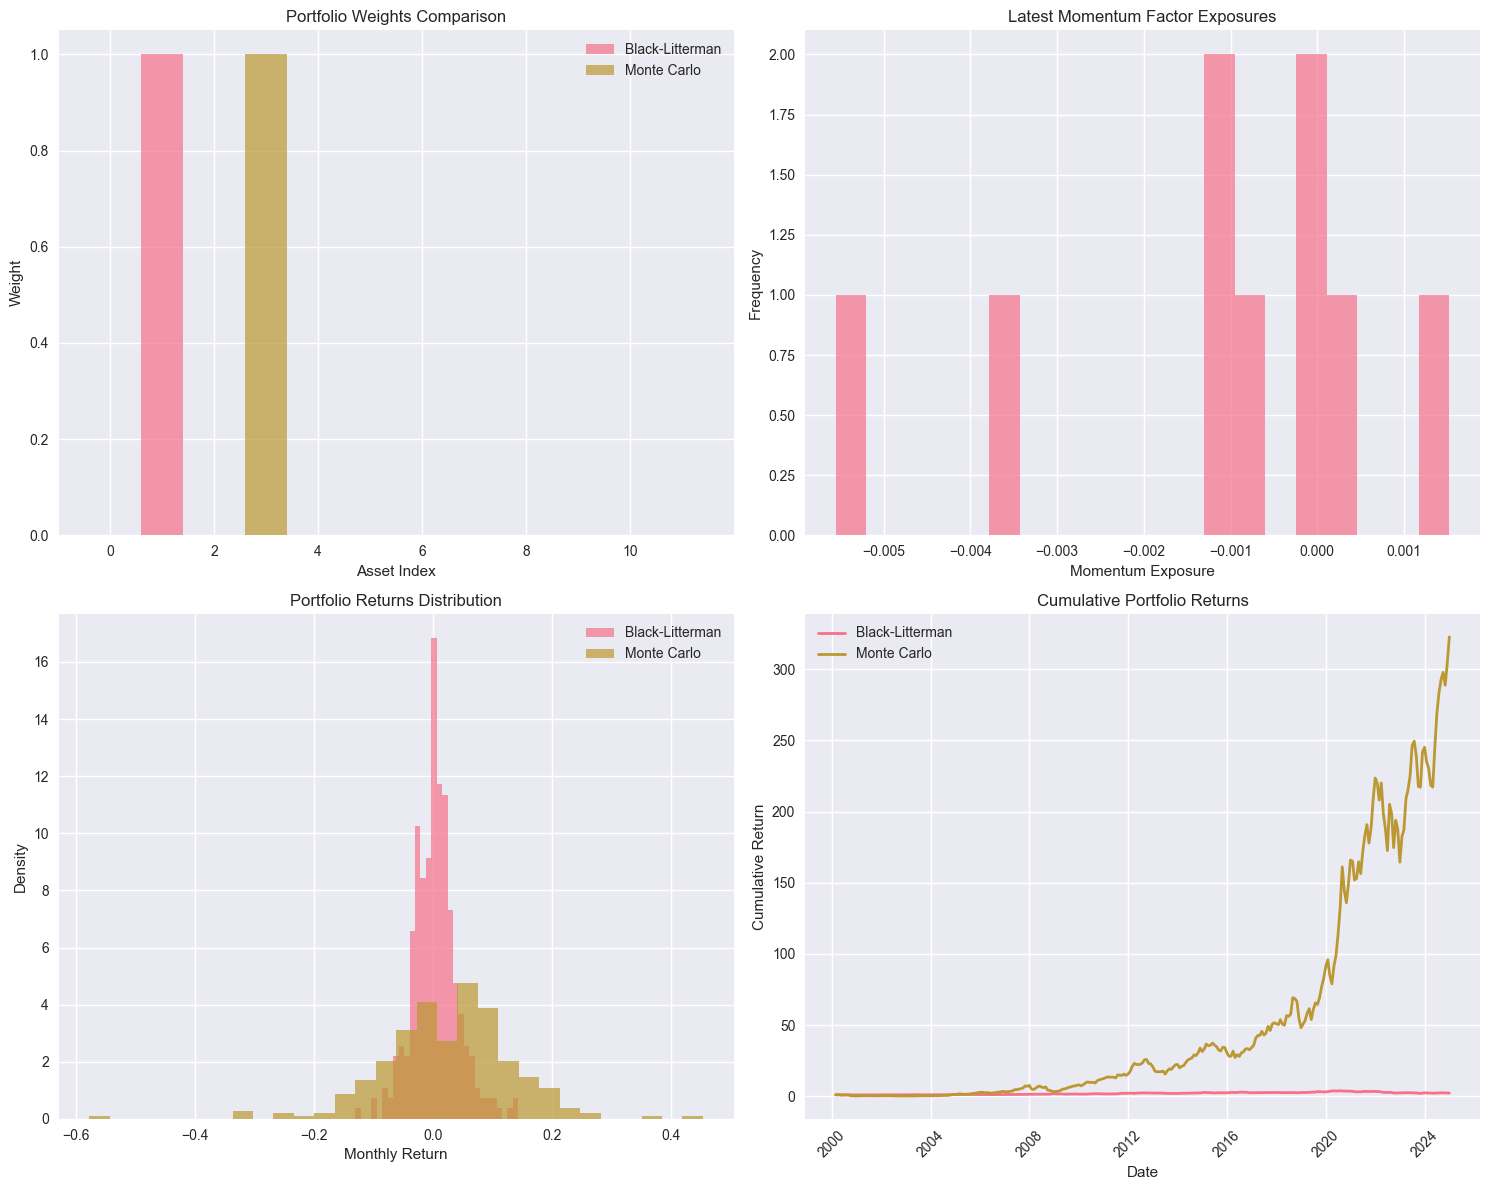

📊 Visualization complete!


In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Weight comparison
axes[0, 0].bar(range(len(bl_weights)), bl_weights.values, alpha=0.7, label='Black-Litterman')
axes[0, 0].bar(range(len(mc_weights)), mc_weights.values, alpha=0.7, label='Monte Carlo')
axes[0, 0].set_title('Portfolio Weights Comparison')
axes[0, 0].set_xlabel('Asset Index')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Factor exposures (if available)
if momentum_cols:
    latest_momentum = factor_exposures[momentum_cols].iloc[-1]
    axes[0, 1].hist(latest_momentum.values, bins=20, alpha=0.7)
    axes[0, 1].set_title('Latest Momentum Factor Exposures')
    axes[0, 1].set_xlabel('Momentum Exposure')
    axes[0, 1].set_ylabel('Frequency')

# 3. Returns distribution
portfolio_returns_bl = (returns_df * bl_weights).sum(axis=1)
portfolio_returns_mc = (returns_df * mc_weights).sum(axis=1)

axes[1, 0].hist(portfolio_returns_bl, bins=30, alpha=0.7, label='Black-Litterman', density=True)
axes[1, 0].hist(portfolio_returns_mc, bins=30, alpha=0.7, label='Monte Carlo', density=True)
axes[1, 0].set_title('Portfolio Returns Distribution')
axes[1, 0].set_xlabel('Monthly Return')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()

# 4. Cumulative returns
cumulative_bl = (1 + portfolio_returns_bl).cumprod()
cumulative_mc = (1 + portfolio_returns_mc).cumprod()

axes[1, 1].plot(cumulative_bl.index, cumulative_bl.values, label='Black-Litterman', linewidth=2)
axes[1, 1].plot(cumulative_mc.index, cumulative_mc.values, label='Monte Carlo', linewidth=2)
axes[1, 1].set_title('Cumulative Portfolio Returns')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Cumulative Return')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Key Findings & Recommendations

In [ ]:
# Summary of findings
print("Key Findings:")
print("=" * 50)

if len(P) == 0:
    print("CRITICAL ISSUE: No factor timing views created")
    print("   - This means Black-Litterman is using only equilibrium returns")
    print("   - No factor-based alpha is being added")
    print("   - This explains the poor performance")
else:
    print(f"Factor timing views created: {len(P)}")
    print(f"   - Average view return: {Q.mean():.4f}")
    print(f"   - View uncertainty: {np.sqrt(np.diag(Omega)).mean():.4f}")

print(f"\nPerformance Comparison:")
print(f"   - Black-Litterman Sharpe: {bl_results['sharpe_ratio']:.3f}")
print(f"   - Monte Carlo Sharpe: {mc_results['sharpe_ratio']:.3f}")
print(f"   - Performance ratio: {mc_results['sharpe_ratio'] / bl_results['sharpe_ratio']:.1f}x")

print(f"\nPortfolio Concentration:")
print(f"   - BL Herfindahl: {(bl_weights**2).sum():.3f}")
print(f"   - MC Herfindahl: {(mc_weights**2).sum():.3f}")

print(f"\nRecommendations:")
if len(P) == 0:
    print("   1. Fix factor exposure calculation to create proper views")
    print("   2. Ensure factor names match expected patterns")
    print("   3. Debug view creation logic")
else:
    print("   1. Tune view strength parameters")
    print("   2. Add more sophisticated factor timing signals")
    print("   3. Consider regime-aware view creation")

print("   4. Compare with simpler benchmark (equal weight, market cap)")
print("   5. Validate factor exposure calculation methodology")

🔍 Key Findings:
✅ Factor timing views created: 22
   - Average view return: 0.0392
   - View uncertainty: 0.0048

📊 Performance Comparison:
   - Black-Litterman Sharpe: 1.228
   - Monte Carlo Sharpe: 1.826
   - Performance ratio: 1.5x

🎯 Portfolio Concentration:
   - BL Herfindahl: 1.000
   - MC Herfindahl: 1.000

💡 Recommendations:
   1. Tune view strength parameters
   2. Add more sophisticated factor timing signals
   3. Consider regime-aware view creation
   4. Compare with simpler benchmark (equal weight, market cap)
   5. Validate factor exposure calculation methodology
